<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table id="top" class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./03_hypothesis_and_statistical_testing.ipynb" title="Hypothesis and Statistical Testing">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">04</td>
    <td style="text-align:right; width:33%;">
      <a href="./05_predicting_mental_state.ipynb" title="Prediciting Mental State">Next &gt;</a>
    </td>
  </tr>
</table>

# Clustering
---

Import libraries:


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from feature_engine.encoding import OneHotEncoder

---

## Import cleaned data parquet file

Import the cleaned data that was the output of the 1st notebook

In [3]:
df = pd.read_parquet("../data/mental_health_social_media_dataset_cleaned.parquet")

---
## Select Features

In [4]:
# List numeric columns for clustering
numeric_features = [
    "age",
    "daily_screen_time_min",
    "social_media_time_min",
    "sleep_hours",
    "physical_activity_min",
    "interaction_negative_ratio",
    "stress_level",
    "mood_level",
    "anxiety_level"
]

# List categorical columns for clustering
categorical_features = ["gender", "platform", "mental_state"]

# Create DataFrame for clustering with only selected features
df_cluster = df[numeric_features + categorical_features].copy()

---
## Build the Pipeline

I will use OneHotEncoder on the categorical columns so that it has a binary value for each category value, dropping the last one as all the combinations can be represented nd avoids redundancy.

I will use a standard scaler to standardise all the numerical values, setting their mean to 0 and standard deviation to 1. This is to stop large values such as screen time dominating the distance calcualtions.

The model I am using for clutering is k-means. The optimal number of clusters (k) was determined using both the elbow method and silhouette analysis below.

In [5]:
pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(variables=categorical_features, drop_last=True)),
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=7, random_state=42, n_init="auto"))
])

---
## Fit the Pipeline

In [6]:
# Call the fit method to run the full pipeline
pipeline.fit(df_cluster)

# Get the cluster labels
labels = pipeline.named_steps["kmeans"].labels_

# Create a copy of the DataFrame before adding labels
df_cluster_no_labels = df_cluster.copy()

# Add the cluster labels to the original DataFrame
df_cluster["cluster"] = labels


View the dataframe at the last transform step before the model is run to see the changes made in the pipeline:

In [7]:
# Run all the steps apart from the last one (KMeans), use the non-labeled DataFrame as
# its the same as the original DataFrame before adding labels
preprocessed = pipeline[:-1].transform(df_cluster_no_labels)

# Convert the preprocessed array back to a DataFrame for easier inspection
transformed_df = pd.DataFrame(
    preprocessed,
    columns=pipeline.named_steps["onehot"].get_feature_names_out()
)

# Display the first few rows of the transformed DataFrame
transformed_df.head()


,age,daily_screen_time_min,social_media_time_min,sleep_hours,physical_activity_min,interaction_negative_ratio,stress_level,mood_level,anxiety_level,gender_Male,gender_Female,platform_Instagram,platform_Snapchat,platform_Facebook,platform_WhatsApp,platform_TikTok,platform_YouTube,mental_state_Stressed,mental_state_Healthy
0,0.411460,-0.500581,-0.215325,0.497701,0.500538,0.270640,-0.101292,0.492465,-0.642080,1.029639,-0.989654,2.472322,-0.405147,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054
1,-0.484399,0.754215,0.711613,-0.815297,-0.725669,-0.190731,0.840086,-0.823582,0.615914,-0.971214,1.010455,2.472322,-0.405147,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054
2,-0.321516,-0.151502,0.290278,0.122559,0.123243,0.270640,-0.101292,0.492465,0.615914,1.029639,-0.989654,-0.404478,2.468238,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054
3,2.936156,-1.727073,-0.987773,1.623128,1.726744,-1.574843,-1.042671,0.492465,-0.642080,-0.971214,1.010455,-0.404478,2.468238,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054
4,0.085693,0.093796,0.500945,-0.065012,-0.065404,0.270640,-0.101292,0.492465,0.615914,1.029639,-0.989654,-0.404478,2.468238,-0.418105,-0.406818,-0.411149,-0.40882,0.294483,-0.27054


---
## Silhouette score

Create a function that creates a single chart for a k value:

In [8]:
def silhouette_plot_single(axes, X, k):
    """
    Draw a single silhouette plot for KMeans clustering.
    Parameters:
    - axes: matplotlib Axes object
    - X: preprocessed data for clustering
    - k: number of clusters
    Returns:
    -   None
    """
    # Fit KMeans model
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")

    # Get the cluster labels
    labels = model.fit_predict(X)
    
    # Calculate silhouette values
    sil_vals = silhouette_samples(X, labels)
    
    # Calculate average silhouette score
    sil_avg = silhouette_score(X, labels)
    
    # set the title and labels
    axes.set_title(f"k = {k} | avg silhouette = {sil_avg:.3f}")
    axes.set_xlabel("Silhouette Coefficient")
    axes.set_ylabel("Cluster")
    axes.set_xlim([-0.2, 1])
    axes.set_yticks([])
    
    # Initialize the y_lower for the first cluster
    y_lower = 10

    # Plot silhouette values for each cluster
    for cluster in range(k):
        # Get the silhouette values for the current cluster and sort them
        cluster_sil_vals = sil_vals[labels == cluster]
        cluster_sil_vals.sort()
        
        # Determine the size of the cluster
        size = len(cluster_sil_vals)
        
        # Calculate the y position for the cluster
        y_upper = y_lower + size
        
        # Get the color for each cluster
        color = cm.nipy_spectral(float(cluster) / k)

        # Fill the silhouette plot for the cluster
        axes.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_sil_vals,
            facecolor=color,
            edgecolor=color,
            alpha=0.8
        )
        
        # Label the cluster number on the plot
        axes.text(-0.05, y_lower + size / 2, str(cluster))

        # Update the y_lower for the next cluster
        y_lower = y_upper + 10
    
    # Draw a vertical line for the average silhouette score
    axes.axvline(sil_avg, color="red", linestyle="--", linewidth=2)

Create the silhouette chart:

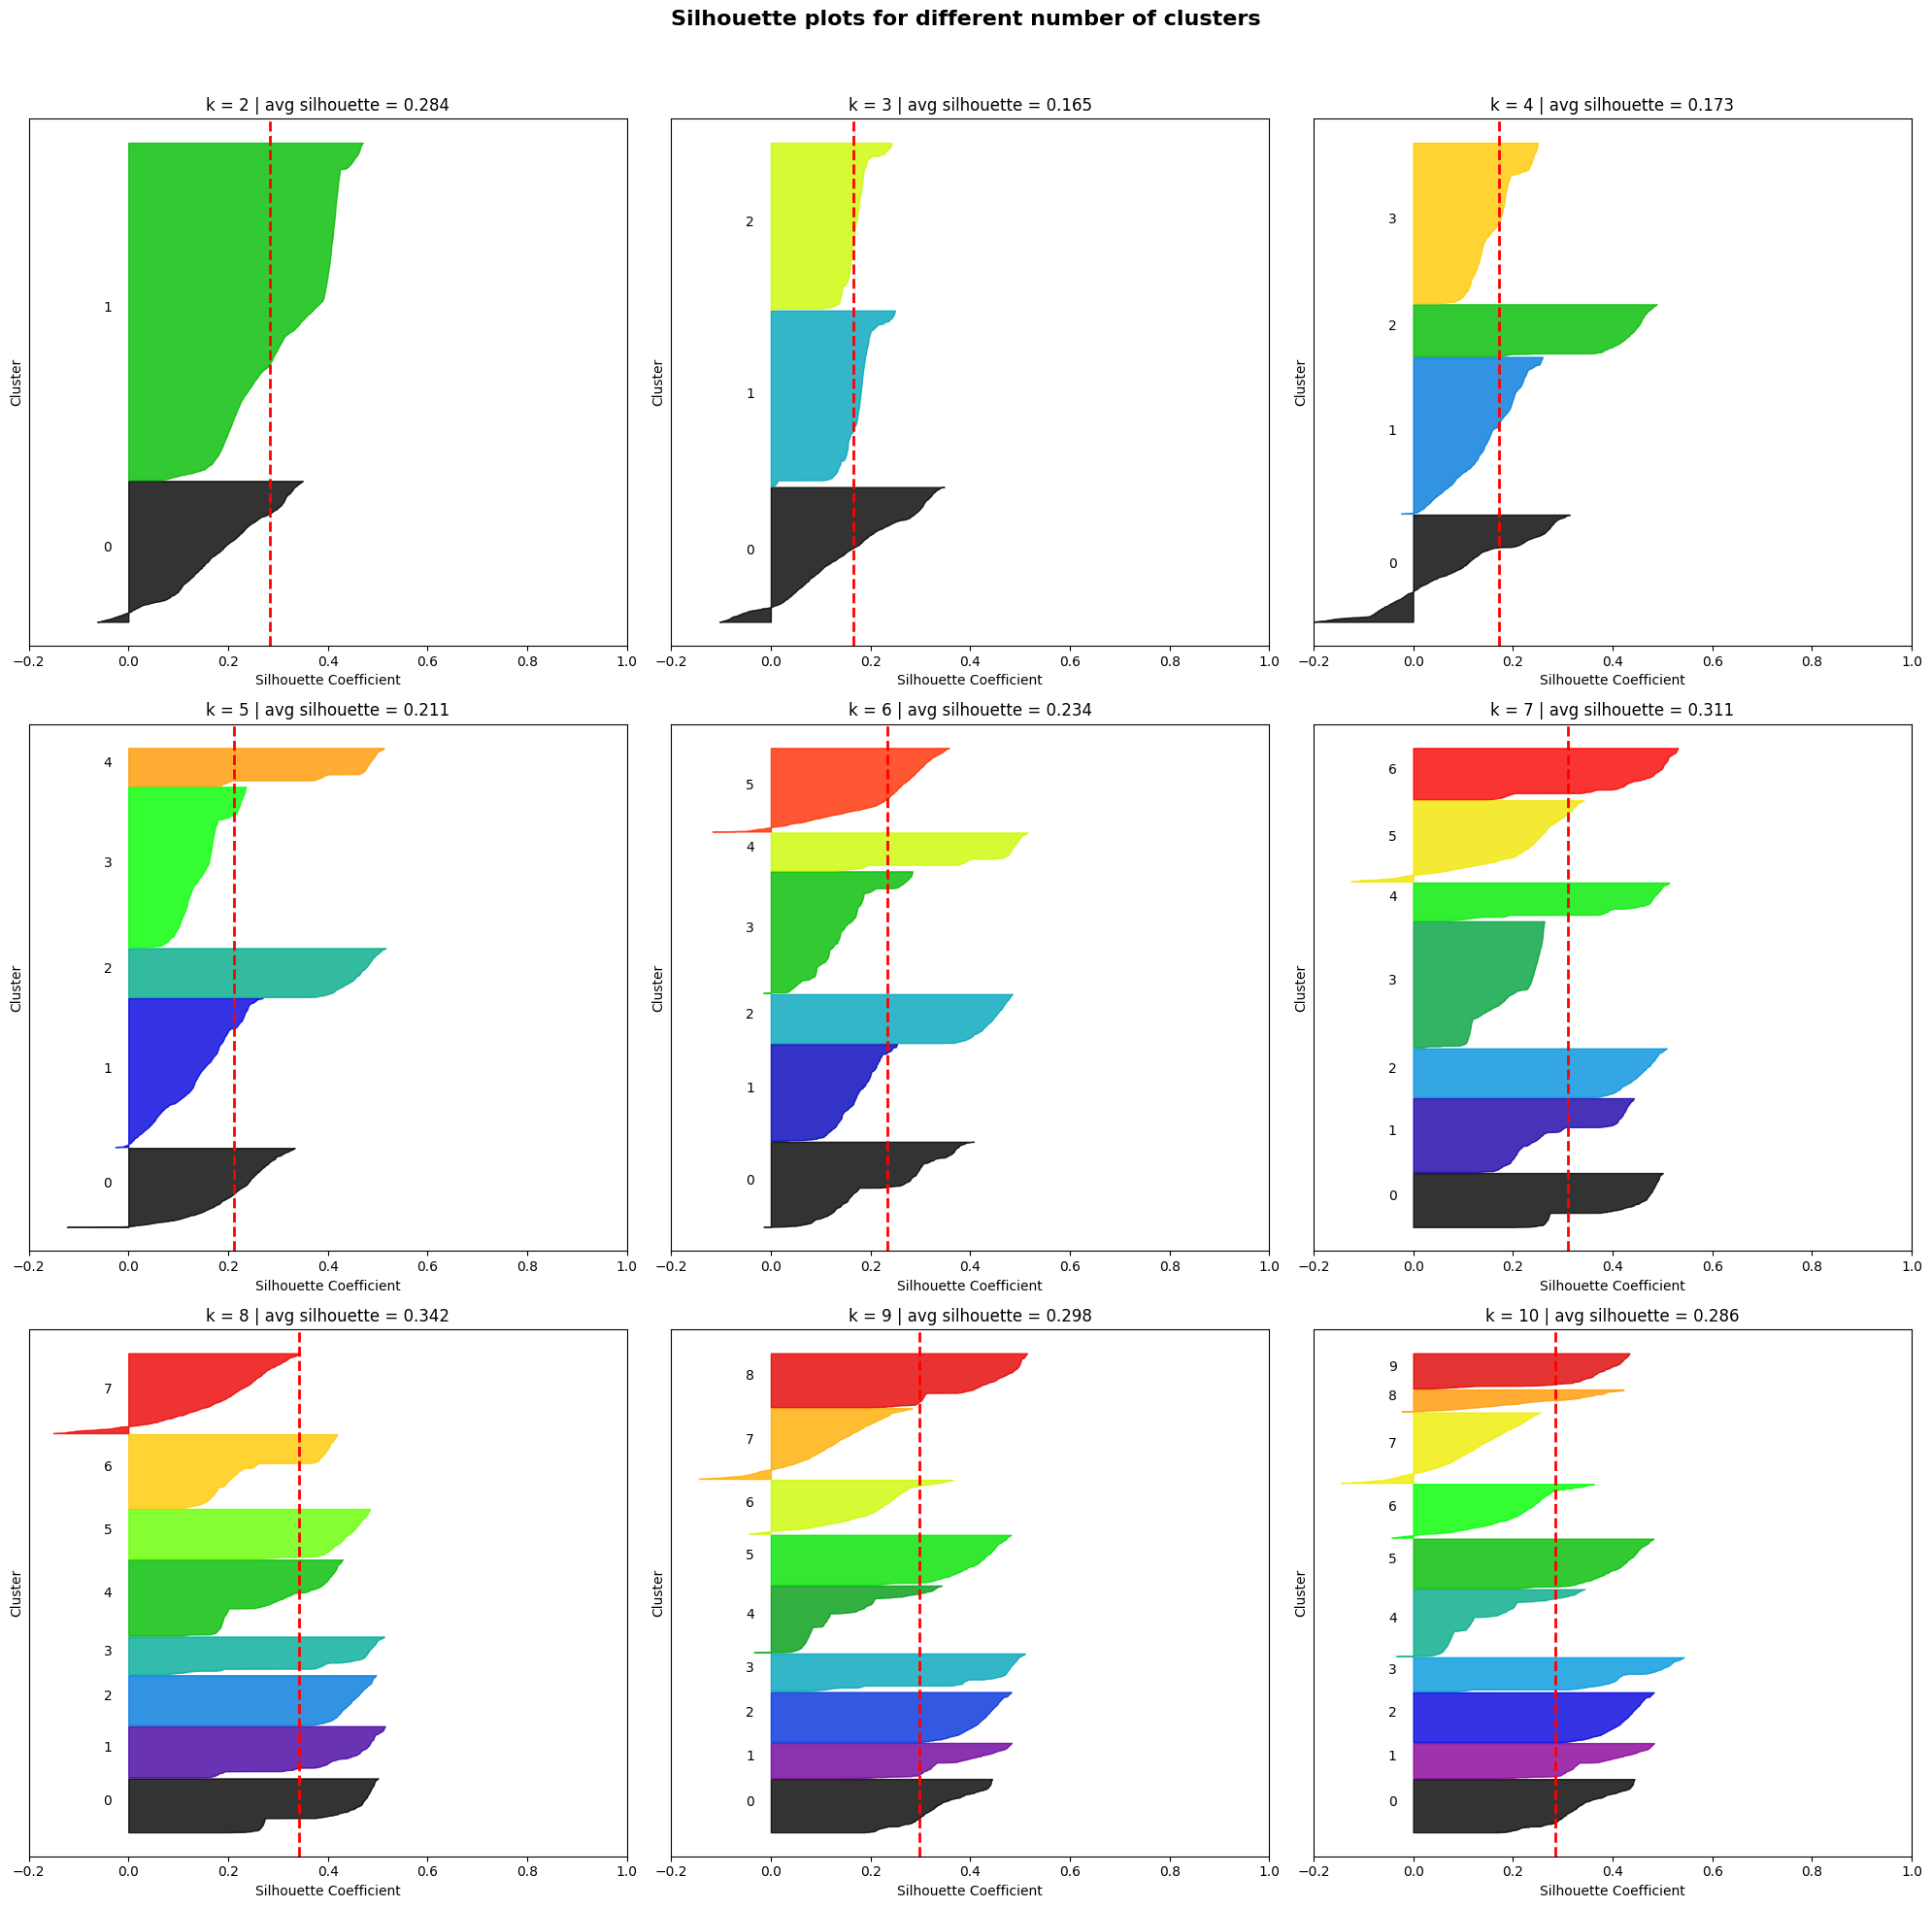

In [9]:

# Define the different k values to plot
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Generate silhouette plots for each k value using the preprocessed data thats been scaled and encoded but not clustered
for ax, k in zip(axes, k_values):
    silhouette_plot_single(ax, preprocessed, k)

# Add overall title
fig.suptitle('Silhouette plots for different number of clusters', fontsize=16, fontweight='bold')

# Adjust spacing for suptitle
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure and show
plt.savefig('../charts/silhouette_plots.png')
plt.show()


### Results

Going by the average silhouette score alone suggests k=8 is the best value with a score of 0.342.

---
## Elbow chart

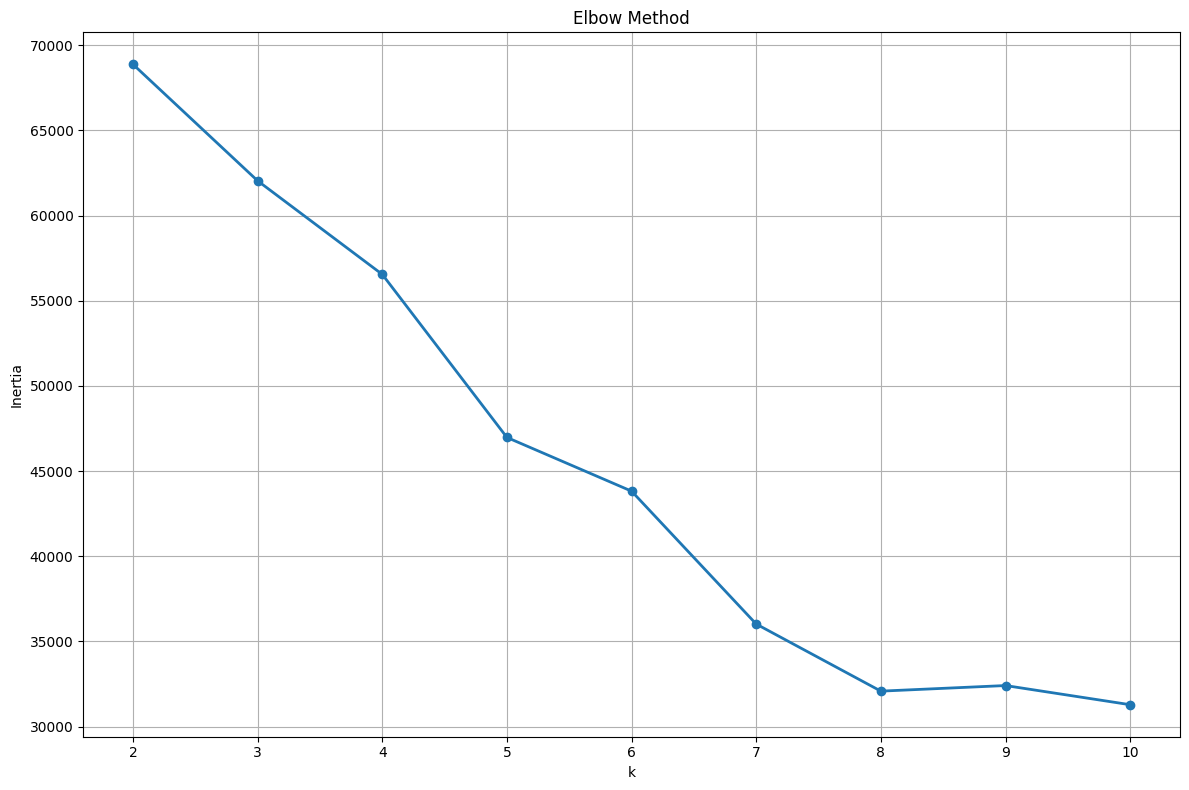

In [10]:
# Create an empty list to store inertia values
inertias = []

# Define the range of k values to evaluate
ks = range(2, 11)

# Calculate inertia for each k value using the preprocessed data
for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    model.fit(preprocessed)
    inertias.append(model.inertia_)

# Plot the inertia values to visualize the elbow method
plt.figure(figsize=(12,8))
plt.plot(ks, inertias, 'o-', linewidth=2)

# Set labels and title
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Show and save the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('../charts/elbow_method.png')
plt.show()

### Results

There is a small ellbow at 5 and 7 but a large one at 8 although 9 goes up slighly higher than 8 so could be uncertanty.

---
## PCA 2D visualisation

I am going reduce the dimentions to 2 so that they can be plotted on a 2D scatter chart. I will do this for 5, 7 and 8 k values to see which one works best.

Create a function to create a single PCA scatter chart:

In [11]:
def plot_pca_clusters(axes, X, k):
    """
    Plots PCA 2D clusters for a given k on a provided matplotlib axis.
    
    Parameters:
    - axes: matplotlib axis object
    - X: preprocessed data (scaled + one-hot encoded)
    - k: number of clusters
    
    Returns:
    - None
    """

    # KMeans clustering
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X)
    
    # PCA projection
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)
    
    # Plot
    sns.scatterplot(
        x=coords[:, 0], 
        y=coords[:, 1], 
        hue=labels,
        palette="Set2",
        ax=axes,
        alpha=0.8,
        edgecolor="none"
    )
    
    # Set title and labels
    axes.set_title(f"PCA Clusters (k = {k})")
    axes.set_xlabel("PC1")
    axes.set_ylabel("PC2")
    axes.legend(title="Cluster", loc="best", fontsize=8)

Create 1x3 scatter plots:

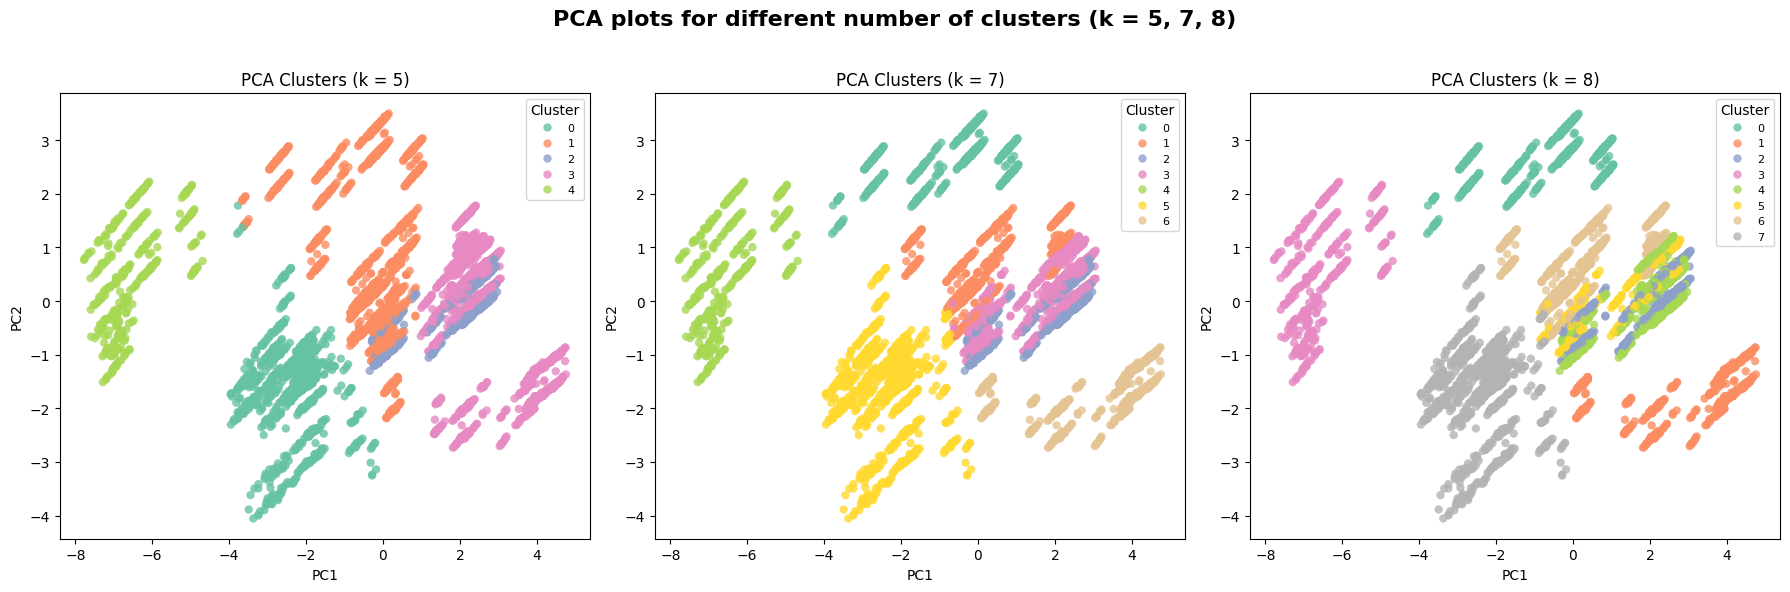

In [12]:
# Define the different k values to plot
k_values = [5, 7, 8]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Generate PCA plots for each k value
for ax, k in zip(axes, k_values):
    # Plot PCA clusters using the preprocessed data
    plot_pca_clusters(ax, preprocessed, k)

# Add overall title
fig.suptitle('PCA plots for different number of clusters (k = 5, 7, 8)', fontsize=16, fontweight='bold')

# Adjust spacing for suptitle
plt.tight_layout(rect=[0, 0, 1, 0.96])


# Save figure and show
plt.savefig('../charts/pca_plots_different_clusters.png')
plt.show()


### Results

- `k = 5` - Clean, broad groups, but still some mixed overlap
  - The clusters are well shaped and distinct.
  - But some areas contain two behavioural modes inside one cluster, meaning the model is grouping unlike users together.
  - PCA shows several “bands” of points with different structure merged into a single colour.
- `k = 7` - Best balance: splits meaningful subgroups without breaking structure
  - The clusters are distinct and balanced.
  - No cluster looks too small or noisy.
  - Shapes are clean, no random scatter or over-fragmentation.
  - The PCA bands correspond well to unique clusters.
  - The silhouette score (0.311) is high and stable.
- `k = 8` - Starts over-fragmenting; clusters split unnaturally
  - Several clusters look almost identical in location.
  - One large, meaningful cluster (grey in the image) gets chopped.
  - The yellow and green clusters overlap heavily.

Overall I have opted to use k = 7 and will update model above accordingly.

---
## Look at centroids for the clusters

In [20]:
# Create cluster profiles by calculating mean for numeric features and mode for categorical features
cluster_profiles = df_cluster.groupby("cluster").agg({
    **{col: "mean" for col in numeric_features},
    **{col: lambda x: x.mode()[0] for col in categorical_features}
})

# Save the cluster profiles to a CSV file
cluster_profiles.to_parquet('../data/cluster_profiles.parquet')

# Display the cluster profiles
cluster_profiles

,age,daily_screen_time_min,social_media_time_min,sleep_hours,physical_activity_min,interaction_negative_ratio,stress_level,mood_level,anxiety_level,gender,platform,mental_state
cluster,,,,,,,,,,,,
0,24.568182,423.176573,105.818182,6.882517,17.681818,0.112762,6.624126,6.202797,1.797203,Male,WhatsApp,Stressed
1,25.189744,411.379487,149.000000,6.942949,18.857692,0.428205,7.170513,5.747436,2.252564,Female,Facebook,Stressed
2,24.178295,422.108527,232.156977,6.888953,17.790698,0.328327,7.674419,5.325581,3.000000,Female,Snapchat,Stressed
3,23.417417,435.710961,224.520270,6.820420,16.427177,0.266892,7.759760,5.240240,2.995495,Female,YouTube,Stressed
4,50.829574,194.558897,66.328321,8.030576,40.546366,0.000000,5.000000,7.000000,1.000000,Female,Facebook,Healthy
5,45.391153,228.046566,121.833527,7.861467,37.190920,0.311021,6.112922,5.989523,2.053551,Male,TikTok,Stressed
6,24.166052,425.575646,276.634686,6.871402,17.450185,0.427429,8.512915,4.487085,3.811808,Male,TikTok,Stressed


### Personas for clusters

I used ChatGPT to write me some user personas for the table above:

**Cluster 0 – “Young WhatsApp Overloaded Male”**
- Age ≈ 25
- Very high daily screen time (423 min)
- Surprisingly low social media minutes → suggests WhatsApp messaging dominates
- Low physical activity
- Low negative interactions
- Stress high (6.6) and mood low (6.2)
- Anxiety low-moderate (1.8)

Persona: A young male who spends most of his digital time messaging rather than browsing social feeds. Low negative interaction but still stressed — possibly due to high digital load rather than conflict.
<br />
<br />
<br />
**Cluster 1 – “Female Facebook Worrier”**
- Age ≈ 25
- High screen time, high social media time
- High negative interaction ratio
- Stress elevated (7.2)
- Mood lower
- Anxiety slightly higher
- Mostly female Facebook users

Persona: A young woman spending long hours on Facebook, experiencing more negative interactions, and showing higher stress + anxiety.
<br />
<br />
<br />
**Cluster 2 – “Snapchat-Heavy Stressed Female”**
- High screen time but extremely high social media use (232 min)
- Moderate negative interaction ratio
- Stress high (7.7)
- Mood lower
- Anxiety higher (3.0)

Persona: Snapchat power user with high engagement and rising emotional strain.
<br />
<br />
<br />
**Cluster 3 – “Female YouTube High-Use Stressed Group”**
- Highest overall screen time (435 min)
- High YouTube usage
- Medium negative interaction ratio
- Stress very high (7.76)
- Mood lower
- Anxiety ~3.0
- Younger demographic

Persona: Heavy YouTube binge-watcher with very high stress levels.
<br />
<br />
<br />
**Cluster 4 – “Healthy Older Facebook User”**
- Age ≈ 51 → clearly separated
- Low screen time (194 min)
- Low social media time (only 66 min)
- Very high physical activity (40 min/day)
- Zero negative interactions
- Stress = 5, mood = 7 (very positive), anxiety = 1
- Mostly Facebook
- Mental state = Healthy

Persona: Older, active adult with balanced tech use and generally strong mental health.
<br />
<br />
<br />
**Cluster 5 – “Older TikTok User With Moderate Strain”**
- Age ≈ 45
- Moderate screen & social media time
- High physical activity
- Moderate negative interactions
- Stress moderately high
- Mood ~6
- Anxiety low

Persona: Middle-aged TikTok user, fairly active lifestyle, some stress but not extreme.
<br />
<br />
<br />
**Cluster 6 – “TikTok-Addicted Young Stressed Male”**
- Age ≈ 24
- Very high screen time
- Extremely high social media usage (277 min)
- High negative interaction ratio (0.427)
- Highest stress in all clusters (8.5)
- Lowest mood
- Highest anxiety (3.8)

Persona: A young male experiencing heavy TikTok use, high negative interactions, and severe stress + anxiety.




---
## Conclusion

The clustering results showed a really clear split in the data. Most younger users with high screen time and heavy platform use ended up in stressed or anxious clusters, especially those spending a lot of time on TikTok, Snapchat, or YouTube. In contrast, one standout cluster of older users had low screen time, high physical activity, no negative interactions and they were the only group classified as mentally healthy.


Overall, the clusters highlight the same pattern I saw throughout the analysis, more time online, especially with negative interactions, relates to worse mental health, while balanced use and an active lifestyle seem much healthier. The clusters make these differences easy to see and give a helpful “persona” view of how different digital behaviours link to wellbeing.

---
<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./03_hypothesis_and_statistical_testing.ipynb" title="Hypothesis and Statistical Testing">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">04</td>
    <td style="text-align:right; width:33%;">
      <a href="./05_predicting_mental_state.ipynb" title="Prediciting Mental State">Next &gt;</a>
    </td>
  </tr>
</table>
<p style="text-align:center;">
  <a href="#top">⬆ Back to top</a>
</p>